## Librairies + importation

In [180]:
from pathlib import Path
from pyomeca import Analogs
from scipy import signal, fftpack, fft, integrate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
import feather
import csv
import re
import seaborn.objects as so
import matplotlib as mpl
import os
from scipy.signal import butter, filtfilt
from scipy.stats import chi2
from matplotlib.patches import Ellipse
from itertools import chain
import configparser
import tkinter as tk
from tkinter import filedialog

# Data_Path = Path(
#     "C:\\Users\\l.boisson\\Documents\\LPG\\Manips"
# )

sns.set_theme()
sns.set_style("white")

In [181]:
# Create a GUI window
root = tk.Tk()
root.withdraw()  # Hide the main window

# Ask user to select the data folder using a file explorer dialog
# Check if data_folder_path is already loaded in Jupyter variables
try:
    data_folder_path
except NameError:
    data_folder_path = None

if data_folder_path is None:
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    # Open file explorer dialog to select the data folder
    data_folder_path = filedialog.askdirectory(title="Select Data Folder")

    if not data_folder_path:
        print("No folder selected. Exiting.")
        exit()
Data_Path = Path(data_folder_path)

## Définition des fonctions

In [182]:
def extract_file_info(file_path):
    match = re.match(r"(\d{3})_([A-Z]+)_([A-Z]+)_([A-Z]+(?:_\d{2,3})?)_(\d{2})", file_path)
    
    if match:
        participant = match.group(1)
        groupe = match.group(2)
        condition = match.group(3)
        contraction = match.group(4)
        essai = match.group(5)
        
        return {
            "participant": participant,
            "groupe": groupe,
            "condition": condition,
            "contraction": contraction,
            "essai": essai
        }
    else:
        return None

def calcul_ratio(x):
    eversion_values = x.loc[x.index.get_level_values('mouvement') == 'Eversion', 'torque peak '].values
    inversion_values = x.loc[x.index.get_level_values('mouvement') == 'Inversion', 'torque peak '].values
    
    return inversion_values[0] / eversion_values[0]

## Extraction données répétitions

In [183]:
df_column = pd.DataFrame()

for filename in Data_Path.glob("**/*.cxp"):
    file_path = filename.as_posix()
    file_info = extract_file_info(filename.name)

    if file_info is not None:
        contraction_type = file_info["contraction"]
        if contraction_type in ["INV", "EV"]:
            data = pd.read_table(
                filename.as_posix(),
                on_bad_lines="skip",
                encoding="utf-8",
                skiprows=134,
                header=0,
                nrows=14,
                names=["variable", "1"],
            )
        else:
            data = pd.read_table(
                filename.as_posix(),
                on_bad_lines="skip",
                encoding="utf-8",
                skiprows=193,
                header=0,
                nrows=14,
                names=["variable", "1", "2", "3"],
            )
        data = data.assign(**file_info)

        df_column = pd.concat([df_column, data])

df_column["mouvement"] = df_column["variable"].str.extract(r"(\d+)$")
df_column["variable"] = df_column["variable"].str.replace(r"\d+$", "")
df_column["mouvement"] = df_column["mouvement"].astype(int)
df_column["mouvement"] = df_column["mouvement"].replace({1: "Inversion", 2: "Eversion"})

if "INV" in df_column["contraction"].values:
    df_column = df_column[~((df_column["contraction"] == "INV") & (df_column["mouvement"] == "Eversion"))]

if "EV" in df_column["contraction"].values:
    df_column = df_column[~((df_column["contraction"] == "EV") & (df_column["mouvement"] == "Inversion"))]

df_column["contraction"] = df_column["contraction"].apply(lambda x: "ISO" if x in ["EV", "INV"] else x)
df_column['Angle'] = df_column['contraction'].apply(lambda x: 30 if x == 'EXC' else (60 if x == 'CON_60' else (120 if x == 'CON_120' else 0)))

df_result = df_column.melt(
    id_vars=[
        "participant",
        "groupe",
        "condition",
        "contraction",
        "essai",
        "mouvement",
        "Angle",
        "variable"
    ],
    value_vars=["1", "2", "3"],
    var_name="Repetition",
    value_name="Valeur",
)

df_result["Valeur"] = df_result["Valeur"].abs()
df_result = df_result[
    [
        "participant",
        "groupe",
        "condition",
        "contraction",
        "essai",
        "variable",
        "Repetition",
        "mouvement",
        "Angle",
        "Valeur"
    ]
]
df_result.columns = [
    "participant",
    "groupe",
    "condition",
    "contraction",
    "essai",
    "Variable",
    "Repetition",
    "mouvement",
    "Angle",
    "Valeur"
]

df_result = pd.pivot_table(
    df_result,
    index=[
        "participant",
        "groupe",
        "condition",
        "contraction",
        "essai",
        "Repetition",
        "mouvement",
        "Angle",
    ],
    columns=["Variable"],
    values="Valeur",
)

df_result

C:\Users\l.boisson\AppData\Local\Temp\ipykernel_20644\835359385.py:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df_column["variable"] = df_column["variable"].str.replace(r"\d+$", "")


Variable                                                                   power avg   \
participant groupe condition contraction essai Repetition mouvement Angle               
003         HUB    PRE       CON_120     01    1          Eversion  120     15.648189   
                                                          Inversion 120      8.248739   
                                               2          Eversion  120     16.214233   
                                                          Inversion 120      8.562557   
                                               3          Eversion  120     15.750763   
...                                                                               ...   
010         HUB    PRE       EXC         02    3          Inversion 30       9.754354   
                             ISO         01    1          Eversion  0        0.000380   
                                                          Inversion 0        0.000360   
                                         02    1          Eversion  0        0.000378   
                                                          Inversion 0        0.000221   

Variable                                                                   power peak   \
participant groupe condition contraction essai Repetition mouvement Angle                
003         HUB    PRE       CON_120     01    1          Eversion  120      28.216496   
                                                          Inversion 120      16.567691   
                                               2          Eversion  120      28.482862   
                                                          Inversion 120      15.542401   
                                               3          Eversion  120      28.402743   
...                                                                                ...   
010         HUB    PRE       EXC         02    3          Inversion 30       15.047704   
                             ISO         01    1          Eversion  0         0.082861   
                                                          Inversion 0         0.064344   
                                         02    1          Eversion  0         0.080219   
                                                          Inversion 0         0.061331   

Variable                                                                   speed peak   \
participant groupe condition contraction essai Repetition mouvement Angle                
003         HUB    PRE       CON_120     01    1          Eversion  120     120.286804   
                                                          Inversion 120     119.505722   
                                               2          Eversion  120     120.286804   
                                                          Inversion 120     115.600304   
                                               3          Eversion  120     120.677345   
...                                                                                ...   
010         HUB    PRE       EXC         02    3          Inversion 30       30.462244   
                             ISO         01    1          Eversion  0         0.390542   
                                                          Inversion 0         0.390542   
                                         02    1          Eversion  0         0.390542   
                                                          Inversion 0         0.390542   

Variable                                                                   speed peak pos   \
participant groupe condition contraction essai Repetition mouvement Angle                    
003         HUB    PRE       CON_120     01    1          Eversion  120          14.228833   
                                                          Inversion 120          10.433257   
                                               2          Eversion  120           6.151030   
                              

## Colonne ratio agoniste/antagoniste

In [184]:
df_result["ratio"] = df_result.groupby(
    ["participant", "groupe", "condition", "contraction", "essai", "Repetition"]
).apply(calcul_ratio)

df_result

Variable                                                                   power avg   \
participant groupe condition contraction essai Repetition mouvement Angle               
003         HUB    PRE       CON_120     01    1          Eversion  120     15.648189   
                                                          Inversion 120      8.248739   
                                               2          Eversion  120     16.214233   
                                                          Inversion 120      8.562557   
                                               3          Eversion  120     15.750763   
...                                                                               ...   
010         HUB    PRE       EXC         02    3          Inversion 30       9.754354   
                             ISO         01    1          Eversion  0        0.000380   
                                                          Inversion 0        0.000360   
                                         02    1          Eversion  0        0.000378   
                                                          Inversion 0        0.000221   

Variable                                                                   power peak   \
participant groupe condition contraction essai Repetition mouvement Angle                
003         HUB    PRE       CON_120     01    1          Eversion  120      28.216496   
                                                          Inversion 120      16.567691   
                                               2          Eversion  120      28.482862   
                                                          Inversion 120      15.542401   
                                               3          Eversion  120      28.402743   
...                                                                                ...   
010         HUB    PRE       EXC         02    3          Inversion 30       15.047704   
                             ISO         01    1          Eversion  0         0.082861   
                                                          Inversion 0         0.064344   
                                         02    1          Eversion  0         0.080219   
                                                          Inversion 0         0.061331   

Variable                                                                   speed peak   \
participant groupe condition contraction essai Repetition mouvement Angle                
003         HUB    PRE       CON_120     01    1          Eversion  120     120.286804   
                                                          Inversion 120     119.505722   
                                               2          Eversion  120     120.286804   
                                                          Inversion 120     115.600304   
                                               3          Eversion  120     120.677345   
...                                                                                ...   
010         HUB    PRE       EXC         02    3          Inversion 30       30.462244   
                             ISO         01    1          Eversion  0         0.390542   
                                                          Inversion 0         0.390542   
                                         02    1          Eversion  0         0.390542   
                                                          Inversion 0         0.390542   

Variable                                                                   speed peak pos   \
participant groupe condition contraction essai Repetition mouvement Angle                    
003         HUB    PRE       CON_120     01    1          Eversion  120          14.228833   
                                                          Inversion 120          10.433257   
                                               2          Eversion  120           6.151030   
                              

## Rename colonnes

In [185]:
df_result.columns = ['Puissance_moyenne', 
                     'Pic_puissance', 
                     'Pic_vitesse', 
                     'Position_pic_vitesse', 
                     'Pic_force', 
                     'Position_pic_force', 
                     'Travail', 
                     'Ratio_ago_anta'
                     ]

df_result

Puissance_moyenne  \
participant groupe condition contraction essai Repetition mouvement Angle                      
003         HUB    PRE       CON_120     01    1          Eversion  120            15.648189   
                                                          Inversion 120             8.248739   
                                               2          Eversion  120            16.214233   
                                                          Inversion 120             8.562557   
                                               3          Eversion  120            15.750763   
...                                                                                      ...   
010         HUB    PRE       EXC         02    3          Inversion 30              9.754354   
                             ISO         01    1          Eversion  0               0.000380   
                                                          Inversion 0               0.000360   
                                         02    1          Eversion  0               0.000378   
                                                          Inversion 0               0.000221   

                                                                           Pic_puissance  \
participant groupe condition contraction essai Repetition mouvement Angle                  
003         HUB    PRE       CON_120     01    1          Eversion  120        28.216496   
                                                          Inversion 120        16.567691   
                                               2          Eversion  120        28.482862   
                                                          Inversion 120        15.542401   
                                               3          Eversion  120        28.402743   
...                                                                                  ...   
010         HUB    PRE       EXC         02    3          Inversion 30         15.047704   
                             ISO         01    1          Eversion  0           0.082861   
                                                          Inversion 0           0.064344   
                                         02    1          Eversion  0           0.080219   
                                                          Inversion 0           0.061331   

                                                                           Pic_vitesse  \
participant groupe condition contraction essai Repetition mouvement Angle                
003         HUB    PRE       CON_120     01    1          Eversion  120     120.286804   
                                                          Inversion 120     119.505722   
                                               2          Eversion  120     120.286804   
                                                          Inversion 120     115.600304   
                                               3          Eversion  120     120.677345   
...                                                                                ...   
010         HUB    PRE       EXC         02    3          Inversion 30       30.462244   
                             ISO         01    1          Eversion  0         0.390542   
                                                          Inversion 0         0.390542   
                                         02    1          Eversion  0         0.390542   
                                                          Inversion 0         0.390542   

                                                                           Position_pic_vitesse  \
participant groupe condition contraction essai Repetition mouvement Angle                         
003         HUB    PRE       CON_120     01    1          Eversion  120               14.228833   
                                                          Inversion 120               10.433257   
                                               2          Ever

## Profil Force-Vitesse

Régression linéaire

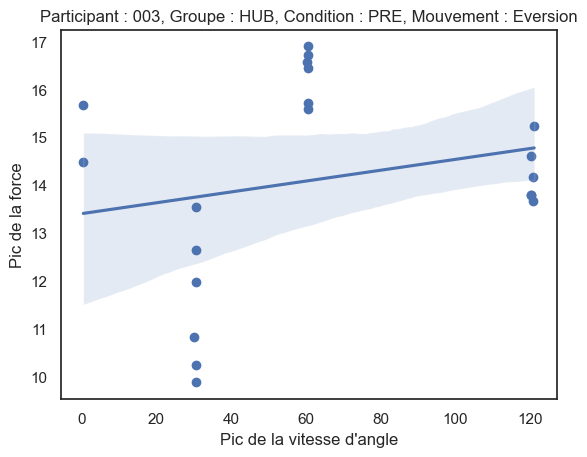

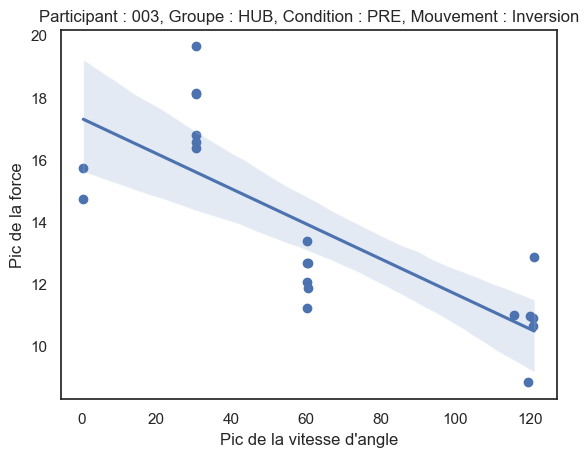

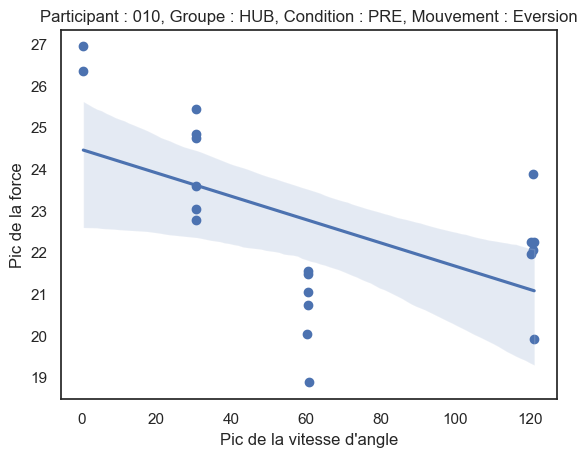

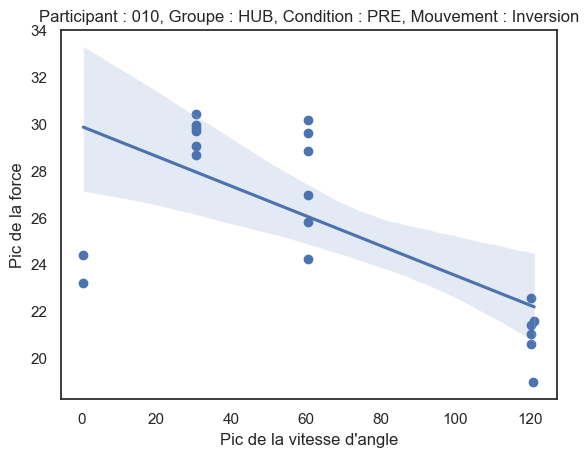

In [186]:
unique_combinations = df_result.groupby(['participant', 'groupe', 'condition', 'mouvement'])
for group, data in unique_combinations:
    plt.scatter(data['Pic_vitesse'], data['Pic_force'], label=group)
    sns.regplot(x=data['Pic_vitesse'], y=data['Pic_force'], scatter=False, label=f'Regression ({group})')
    plt.title(f'Participant : {group[0]}, Groupe : {group[1]}, Condition : {group[2]}, Mouvement : {group[3]}')
    plt.xlabel("Pic de la vitesse d'angle")
    plt.ylabel('Pic de la force')
    plt.show()

## Profil Force-vitesse

Moyenne de la force par groupe

In [187]:
df_result["Moyenne_Pic_force"] = df_result.groupby(
    ["participant", 
     "groupe", 
     "condition",
     "contraction", 
     "mouvement"])['Pic_force'].transform('mean')

df_result

Puissance_moyenne  \
participant groupe condition contraction essai Repetition mouvement Angle                      
003         HUB    PRE       CON_120     01    1          Eversion  120            15.648189   
                                                          Inversion 120             8.248739   
                                               2          Eversion  120            16.214233   
                                                          Inversion 120             8.562557   
                                               3          Eversion  120            15.750763   
...                                                                                      ...   
010         HUB    PRE       EXC         02    3          Inversion 30              9.754354   
                             ISO         01    1          Eversion  0               0.000380   
                                                          Inversion 0               0.000360   
                                         02    1          Eversion  0               0.000378   
                                                          Inversion 0               0.000221   

                                                                           Pic_puissance  \
participant groupe condition contraction essai Repetition mouvement Angle                  
003         HUB    PRE       CON_120     01    1          Eversion  120        28.216496   
                                                          Inversion 120        16.567691   
                                               2          Eversion  120        28.482862   
                                                          Inversion 120        15.542401   
                                               3          Eversion  120        28.402743   
...                                                                                  ...   
010         HUB    PRE       EXC         02    3          Inversion 30         15.047704   
                             ISO         01    1          Eversion  0           0.082861   
                                                          Inversion 0           0.064344   
                                         02    1          Eversion  0           0.080219   
                                                          Inversion 0           0.061331   

                                                                           Pic_vitesse  \
participant groupe condition contraction essai Repetition mouvement Angle                
003         HUB    PRE       CON_120     01    1          Eversion  120     120.286804   
                                                          Inversion 120     119.505722   
                                               2          Eversion  120     120.286804   
                                                          Inversion 120     115.600304   
                                               3          Eversion  120     120.677345   
...                                                                                ...   
010         HUB    PRE       EXC         02    3          Inversion 30       30.462244   
                             ISO         01    1          Eversion  0         0.390542   
                                                          Inversion 0         0.390542   
                                         02    1          Eversion  0         0.390542   
                                                          Inversion 0         0.390542   

                                                                           Position_pic_vitesse  \
participant groupe condition contraction essai Repetition mouvement Angle                         
003         HUB    PRE       CON_120     01    1          Eversion  120               14.228833   
                                                          Inversion 120               10.433257   
                                               2          Ever

Affichage profil force-vitesse par mouvement

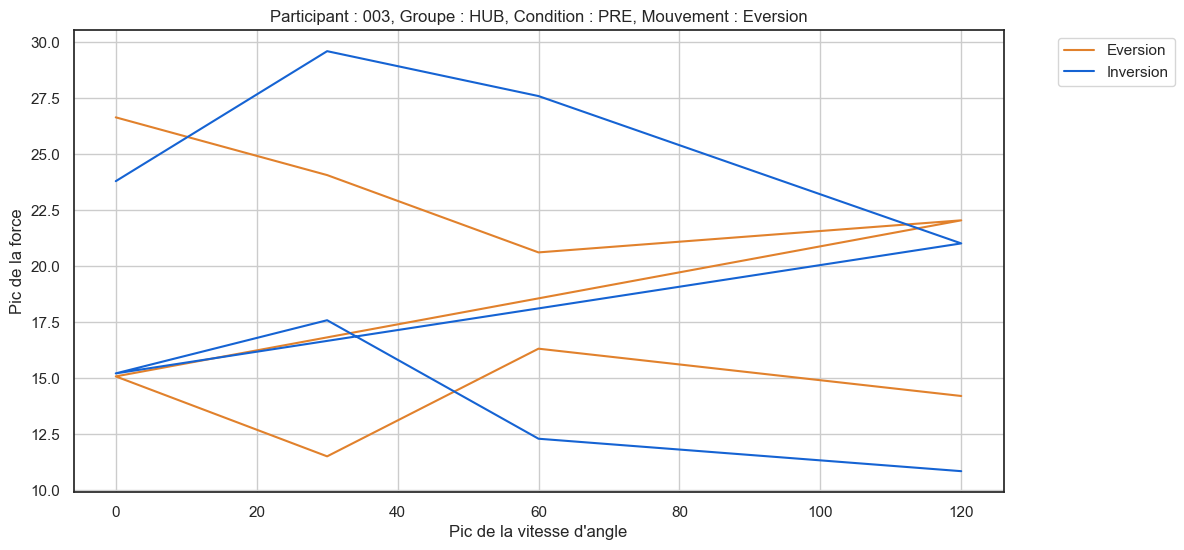

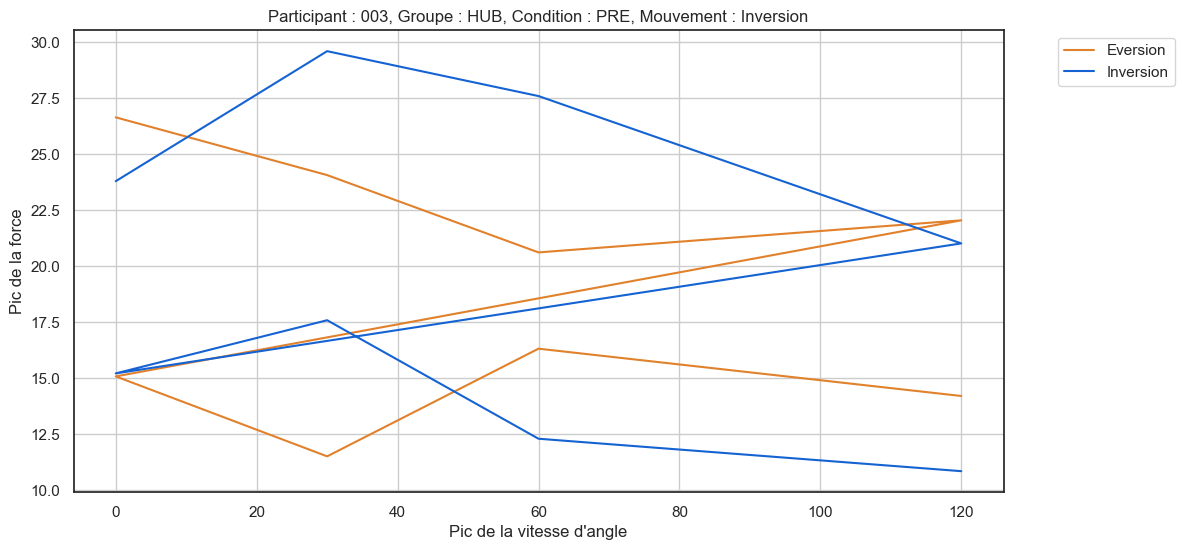

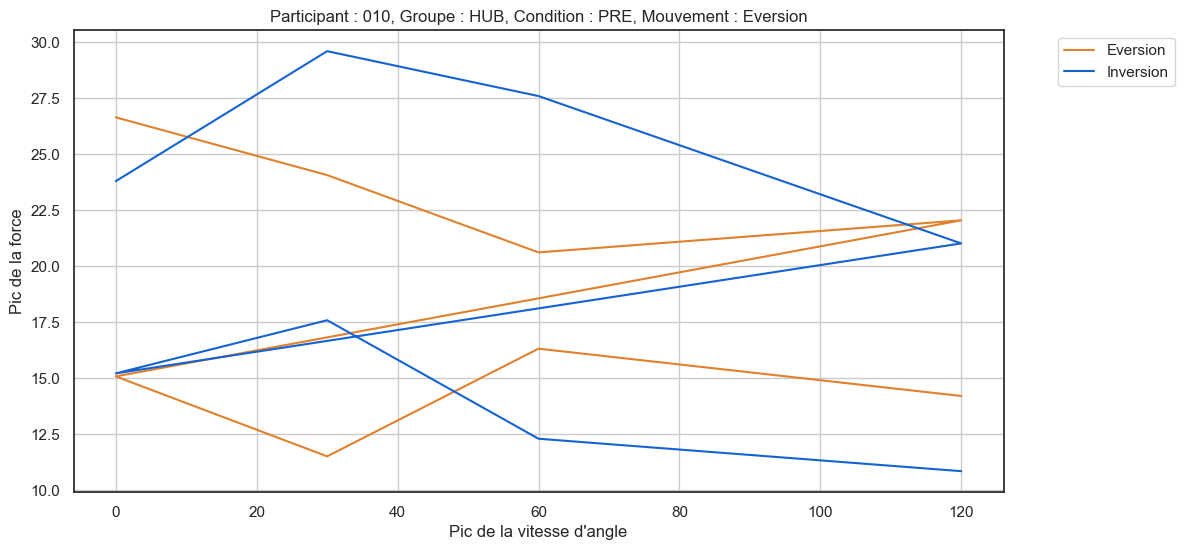

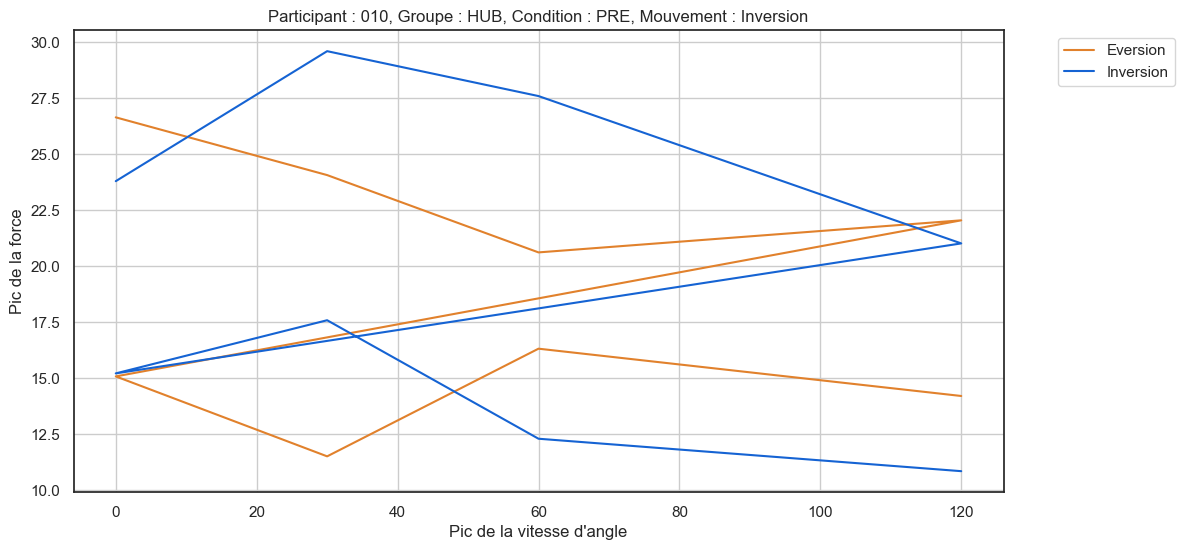

In [197]:
unique_combinations = df_result.groupby(['participant', 'groupe', 'condition', 'mouvement'])
for group, data in unique_combinations:

    df_result_reset = df_result.reset_index()

    eversion_data = df_result_reset[df_result_reset['mouvement'] == "Eversion"]
    inversion_data = df_result_reset[df_result_reset['mouvement'] == "Inversion"]

    plt.figure(figsize=(12, 6))
    plt.plot(eversion_data["Angle"], eversion_data["Moyenne_Pic_force"], label="Eversion", color="#E1812C")
    plt.plot(inversion_data["Angle"], inversion_data["Moyenne_Pic_force"], label="Inversion", color="#1563D3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.title(f'Participant : {group[0]}, Groupe : {group[1]}, Condition : {group[2]}, Mouvement : {group[3]}')
    plt.xlabel("Pic de la vitesse d'angle")
    plt.ylabel('Pic de la force')
    plt.show()

## Extraction données data pour calcul montée en force

In [198]:
df_column = pd.DataFrame()

for filename in Data_Path.glob("**/**/**/**/**/**/*.cxp"):
    file_path = filename.as_posix()
    file_info = extract_file_info(filename.name)
    
    if file_info is not None:
        contraction_type = file_info["contraction"]
        if contraction_type in ["INV", "EV"]:
            skiprows = 151
        else:
            skiprows = 211
        
        data = pd.read_table(
            file_path,
            on_bad_lines='skip',
            encoding='latin-1',
            skiprows=skiprows,
            names=["Force", "Vitesse", "Angle"],
            header=0
        )
        
        data = data.assign(**file_info)
        
        df_column = pd.concat([df_column, data])

df_column['Frame'] = df_column.groupby(["participant", "groupe", "condition", "contraction", "essai"]).cumcount() + 1

df_column['Time'] = df_column['Frame'] / 256
df_column['Force'] = abs(df_column['Force'])
df_column['Vitesse'] = abs(df_column['Vitesse'])
df_column['Angle'] = abs(df_column['Angle'])

df_column = df_column.reset_index(drop=True)
df_column.set_index(["participant", "groupe", "condition", "contraction", "essai", "Frame"], inplace=True)

df_column

Force  Vitesse  Angle  \
participant groupe condition contraction essai Frame                          
003         HUB    PRE       CON_120     01    1      0.044   14.841  8.183   
                                               2      0.054   14.841  8.241   
                                               3      0.064   15.231  8.301   
                                               4      0.125   14.841  8.359   
                                               5      0.074   14.841  8.416   
...                                                     ...      ...    ...   
010         HUB    PRE       INV         02    3828   0.803    0.000  0.134   
                                               3829   0.834    0.000  0.134   
                                               3830   0.773    0.000  0.134   
                                               3831   0.895    0.000  0.134   
                                               3832   0.000    0.000  0.000   

                                                           Time  
participant groupe condition contraction essai Frame             
003         HUB    PRE       CON_120     01    1       0.003906  
                                               2       0.007812  
                                               3       0.011719  
                                               4       0.015625  
                                               5       0.019531  
...                                                         ...  
010         HUB    PRE       INV         02    3828   14.953125  
                                               3829   14.957031  
                                               3830   14.960938  
                                               3831   14.964844  
                                               3832   14.968750  

[78130 rows x 4 columns]

## Calcul Maximal Rate of Force Development

Maximal rate of force development was equal to the highest RFD during 20-millisecond sampling window (23). Maximal rate of force development was expressed in Newton per second and in relative units, i.e., as a percentage of MVF per second 

=> DIURNAL RHYTHM OF MUSCULAR STRENGTH DEPENDS ON TEMPORAL SPECIFICITY OF SELF-RESISTANCE TRAINING
SANA ZBIDI, BADRANE ZINOUBI, HENRY VANDEWALLE, AND TARAK DRISS
Research Center on Sport and Movement (CeRSM, EA 2931), Sciences and Techniques of the Physical and Sporting Activities


The MRFD was equal to the steepest slope calculated for a 20 ms interval. The value of MRFD was expressed in newtons per second and in relative units, ie as a percentage of MVFmax per second

=> MAXIMAL VOLUNTARY FORCE AND RATE OF FORCE DEVELOPMENT IN HUMANS - IMPORTANCE OF INSTRUCTION
R. SAHALY, H. VANDEWALLE, T. DRISS, H. MONOD


Motor units were recruited over an interval starting from contraction onset (range: 22–233 ms).

=> https://journals.physiology.org/doi/full/10.1152/jn.00330.2019

Once contraction onset has been defined, a number of different measures can be obtained from the rising force–time curve. Some of the more common include force at specific time points (Rousanoglou et al. 2010; Tillin et al. 2010) (Fig. 8a) as well as RFD and impulse, which can both be measured over either overlapping periods starting from 0, e.g., RFD/impulse from 0 to 100 ms relative to onset (Aagaard et al. 2002b; Barry et al. 2005) (Fig. 8a), or consecutive periods, e.g., RFD/impulse from 50 to 100 ms Fig. 7 An unfiltered force–time curve recorded during an explosive contraction of the knee extensors (force is expressed relative to maximal voluntary force). Force onset (0 ms) was detected manually/visually using the systematic method detailed in Tillin et al. (2010). Some automated systems for detecting contraction onset have used arbitrary thresholds between 2 and 3.6 % maximal voluntary force which in this example occurs 24–30 ms after manually detected onset. Figure reproduced with permission from Tillin et al. (2013b) Fig. 8 Common measurements of the rising force–time curve. a Force at specific time points (F50, F100, etc.) and overlapping RFD measurements all starting from force onset (RFD0–50, RFD0–100, etc.). b An identical force trace showing measurements of sequential RFD and sequential impulse both assessed over consecutive periods Eur J Appl Physiol (2016) 116:1091–1116 1109 1 3 relative to onset (Folland et al. 2014; Penailillo et al. 2015) (Fig. 8b). Irrespective of the measure, in all cases multiple time points/periods clearly provide a more comprehensive description of the whole rising curve than single measures. In addition, all measures should be corrected for the gravitational force on the limb.

=> Rate of force development: physiological and methodological considerations

 The time to reach the maximum moment ranged from 629 to 659 ms with no signifi cant joint angle eff ect (p > 0. 05). A significant interaction between contraction time and joint angle (p < 0.05) was found for moment ( ●▶ Fig. 2 ). Specifi cally, at contraction times of 30 and 50 ms, the moment was higher near full knee extension, whereas for times ≥ 150 ms, the moment was higher near full knee fl exion ( ●▶ Fig. 2 ). The optimal knee angle obtained for the maximum moment – angle relation was at 61 ° of knee fl exion, whereas the optimal knee angle obtained for the moment-angle relations during the initial time course of the contraction was shifted to more extended knee positions ( ●▶ Fig. 2 ).

=> https://pubmed.ncbi.nlm.nih.gov/20617488/

The athletes were 28% stronger, and their absolute RFD in the first 50 ms was twofold that of controls. Athletes had greater normalized RFD (4.86 ± 1.46 vs 2.81 ± 1.20 MVC·s(-1)) and neural activation (mean quadriceps, 0.26 ± 0.07 vs 0.15 ± 0.06 Mmax) during the first 50 ms of explosive voluntary contractions. 

=> https://pubmed.ncbi.nlm.nih.gov/19952835/

In [190]:
frequency = 256

df_column['Diff_force'] = abs(df_column.groupby(["participant", 
                                                 "groupe", 
                                                 "condition", 
                                                 "contraction", 
                                                 "essai"])['Force'].diff())

df_column['MRFD'] = df_column['Diff_force'] / (1 / frequency * 20 / 1000)

df_column

Force  Vitesse  Angle  \
participant groupe condition contraction essai Frame                          
003         HUB    PRE       CON_120     01    1      0.044   14.841  8.183   
                                               2      0.054   14.841  8.241   
                                               3      0.064   15.231  8.301   
                                               4      0.125   14.841  8.359   
                                               5      0.074   14.841  8.416   
...                                                     ...      ...    ...   
010         HUB    PRE       INV         02    3828   0.803    0.000  0.134   
                                               3829   0.834    0.000  0.134   
                                               3830   0.773    0.000  0.134   
                                               3831   0.895    0.000  0.134   
                                               3832   0.000    0.000  0.000   

                                                           Time  Diff_force  \
participant groupe condition contraction essai Frame                          
003         HUB    PRE       CON_120     01    1       0.003906         NaN   
                                               2       0.007812       0.010   
                                               3       0.011719       0.010   
                                               4       0.015625       0.061   
                                               5       0.019531       0.051   
...                                                         ...         ...   
010         HUB    PRE       INV         02    3828   14.953125       0.030   
                                               3829   14.957031       0.031   
                                               3830   14.960938       0.061   
                                               3831   14.964844       0.122   
                                               3832   14.968750       0.895   

                                                         MRFD  
participant groupe condition contraction essai Frame           
003         HUB    PRE       CON_120     01    1          NaN  
                                               2        128.0  
                                               3        128.0  
                                               4        780.8  
                                               5        652.8  
...                                                       ...  
010         HUB    PRE       INV         02    3828     384.0  
                                               3829     396.8  
                                               3830     780.8  
                                               3831    1561.6  
                                               3832   11456.0  

[77894 rows x 6 columns]

## MRFD par participant, groupe, condition, contraction, essai

In [191]:
max_MRFD = df_column.groupby(['participant', 
                              'groupe', 
                              'condition', 
                              'contraction',
                              'essai'])['MRFD'].max()

max_MRFD_df = max_MRFD.reset_index()

max_MRFD_df

,participant,groupe,condition,contraction,essai,MRFD
0,003,HUB,PRE,CON_120,01,20582.4
1,003,HUB,PRE,CON_120,02,8985.6
2,003,HUB,PRE,CON_60,01,178393.6
3,003,HUB,PRE,CON_60,02,17702.4
4,003,HUB,PRE,EV,01,6246.4
5,003,HUB,PRE,EV,02,4684.8
6,003,HUB,PRE,EXC,01,9382.4
7,003,HUB,PRE,EXC,02,10163.2
8,003,HUB,PRE,INV,01,4300.8
9,003,HUB,PRE,INV,02,5145.6
